# Quantum Walk


This example provides an implementation of the discrete time quantum random walk algorithm (hereafter referred to as quantum walk) using the Amazon Braket SDK. 
One application of quantum walks is to search and find graph properties, including marked vertices, maximal cliques, just to name a few. These problems can be solved via quantum walks provided an oracle that knows the properties of the graph is given. 
We will not get into the details of solving such problems; instead, we will illustrate how to transverse a circular graph, a graph consists of a single cycle, with a quantum walker. 


The quantum walk is very similar to the classical walk, where a walker observes a random process, such as flipping a coin, followed by deciding its next step conditioned on the outcome of the random process. For quantum walker, it observes a quantum process instead, and the subsequent steps are superpositions of the possible steps that a classical walker would take. For example, in this notebook, we consider a quantum walker on a cycle with $N=2^n$ nodes, where each node has only two neighbors. As a result, a classical walker would have two choices at each step, either going to the left or right neighbor, whereas it would be a superposition of the two for the quantum walker. 
More concretely, we will use $|q, k\rangle$ to denote the state of a quantum walker where $q=0,1$ is the state of the coin, and $k\in\left\{0,..,N-1\right\}$ labels the node. 
Each step of the quantum walk is a product of the coin operator (C) and the shift operator (S). 
The coin operator could in principle be any unitary that mixes the coin states, but for simplicity, we use the Hadamard gate 
\begin{align}
C|q,k\rangle = H\otimes I|q,k\rangle = \frac{1}{\sqrt{2}}(|0,k\rangle + (-1)^q|1,k\rangle).
\end{align}
The shift operator moves the walker to the neighboring nodes conditioned on the outcomes of the toss coin followed by flipping the coin state
\begin{align}
S|q,k\rangle = |q\oplus 1, k\oplus(-1)^q\rangle
\end{align}
where $\oplus$ denotes the modular addition: for the first register, the addition is modulo 2 since there are only 2 states for the coin, whereas the addition is modulo $N$ for the second register. 
The quantum walk then proceeds by applying these two operators in alternation, and a $p$ step quantum walk is just the operator $(SC)^p$. 

How do we realize a quantum circuit to perform conditional modular addition? In order to perform modular addition and subtraction, one could invoke the quantum Fourier transform (QFT) adder introduced in Ref. [2](https://arxiv.org/abs/1411.5949). Here we will modify the QFT adder for performing conditional modular addition for the quantum walker. 



# References

[[1] Quantum Algorithm Implementations for Beginners](https://arxiv.org/abs/1804.03719)

[[2] Quantum arithmetic with the Quantum Fourier Transform](https://arxiv.org/abs/1411.5949)

We start by importing the necessary functions

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from braket.devices import LocalSimulator
from braket.tracking import Tracker

%matplotlib inline

from braket.experimental.algorithms.quantum_walk import quantum_walk, run_quantum_walk

tracker = Tracker().start()  # to keep track of Braket costs"

# Quantum walk on a graph with four nodes

As an example, we consider the quantum walk on a graph with 4 nodes as shown in the figure below. Without loss of generality, we shall assume that the walker starts from the vertex labeled as 0. We will demonstrate, step by step, how the walker transverses around the graph and arrive at the opposite corner of the graph.

For that, we define the quantum circuits for quantum walks with 1, 2, 3 and 4 steps.

In [2]:
quantum_walk_circuit_4_nodes_1_step = quantum_walk(4, 1)
quantum_walk_circuit_4_nodes_2_steps = quantum_walk(4, 2)
quantum_walk_circuit_4_nodes_3_steps = quantum_walk(4, 3)
quantum_walk_circuit_4_nodes_4_steps = quantum_walk(4, 4)

We can visualize the quantum circuit for one-step quantum walk as follows. The $n$-step quantum walk for the same graph is simply the $n$-time repetition of the same circuit.

In [3]:
print(quantum_walk_circuit_4_nodes_1_step)

T  : |0|     1     |       2       |     3      |      4      |     5      |6|     7      |8|
                                                                                             
q0 : -H---------------C-------------C------------C-------------C------------X----------------
                      |             |            |             |                             
q1 : ---C-----------H-|-------------|------------PHASE01(3.14)-PHASE(-3.14)-H-C--------------
        |             |             |                                         |              
q2 : -H-PHASE(1.57)---PHASE01(1.57)-PHASE(-1.57)------------------------------PHASE(-1.57)-H-

T  : |0|     1     |       2       |     3      |      4      |     5      |6|     7      |8|


Before proceeding, let us explicitly calculate the states after each step of the quantum walk. Recall that we start with the $0$-th vertex and hence the initial state reads
\begin{align}
|\psi_0\rangle = |00\rangle
\end{align}
where the first register is the coin qubit. After the first step, we have
\begin{align}
|\psi_1\rangle \equiv (SC)|\psi_0\rangle = S\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)\otimes|0\rangle = \frac{1}{\sqrt{2}}\left(|11\rangle+|03\rangle\right)
\end{align}
where we have used the fact $-1\equiv3\text{ mod }4$. After this step, the walker will be in the superposition of the first and third nodes. For the second step we have
\begin{align}
|\psi_2\rangle \equiv (SC)|\psi_1\rangle = \frac{1}{2}\left[|12\rangle-|00\rangle+|10\rangle+|02\rangle\right]
\end{align}
where the walker will be in the superposition of the zeroth and the second nodes. For the third step we have \begin{align}
|\psi_3\rangle \equiv (SC)|\psi_2\rangle = \frac{1}{\sqrt{2}}(|1\rangle-|0\rangle)|3\rangle
\end{align}
where the walker will be in the third node deterministically after the third step. Finally, after the fourth step, we have
\begin{align}
|\psi_4\rangle \equiv (SC)|\psi_3\rangle = -|02\rangle
\end{align}
where the walker end up in the opposite corner, namely the second node, deterministically after the fourth step.

# Run the quantum walk on a local simulator

Let's now run the 4 quantum circuits on a local simulator, followed by measuring the qubits for the nodes. The measurement results are shown with bar plots. 

In [4]:
local_sim = LocalSimulator()
counts_4_nodes_1_step_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_1_step, local_sim)
counts_4_nodes_2_steps_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_2_steps, local_sim)
counts_4_nodes_3_steps_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_3_steps, local_sim)
counts_4_nodes_4_steps_sim = run_quantum_walk(quantum_walk_circuit_4_nodes_4_steps, local_sim)

In [5]:
def plot_bitstrings(counts: Counter, title: str = None):
    plt.bar(counts.keys(), counts.values())
    plt.xticks(list(counts.keys()))
    plt.xlabel("index of the nodes")
    plt.ylabel("probability")
    plt.title(title)
    plt.show()

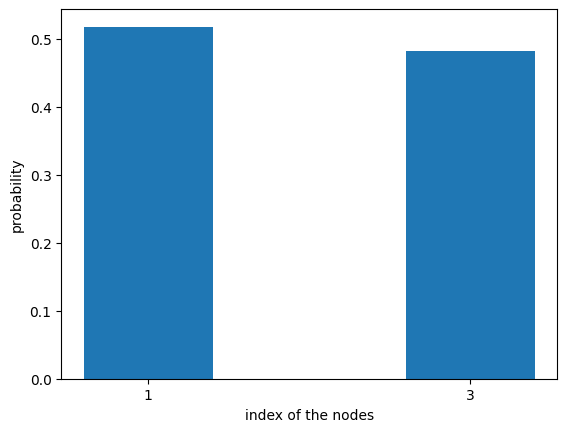

In [6]:
plot_bitstrings(counts_4_nodes_1_step_sim["quantum_walk_measurement_counts"])

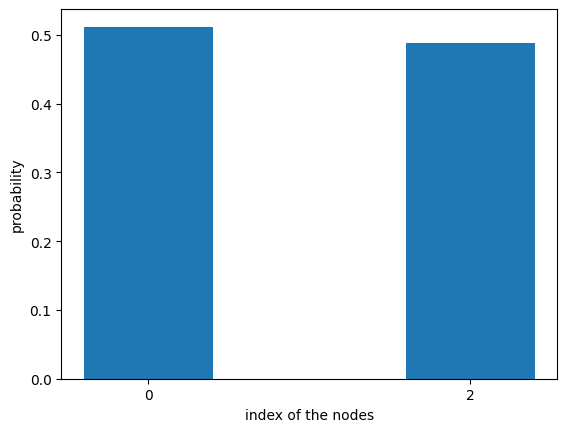

In [7]:
plot_bitstrings(counts_4_nodes_2_steps_sim["quantum_walk_measurement_counts"])

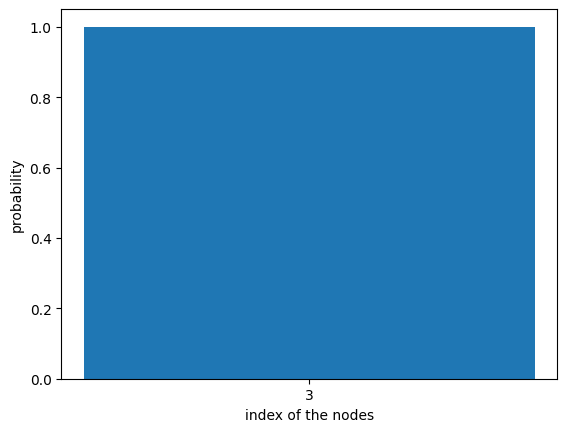

In [8]:
plot_bitstrings(counts_4_nodes_3_steps_sim["quantum_walk_measurement_counts"])

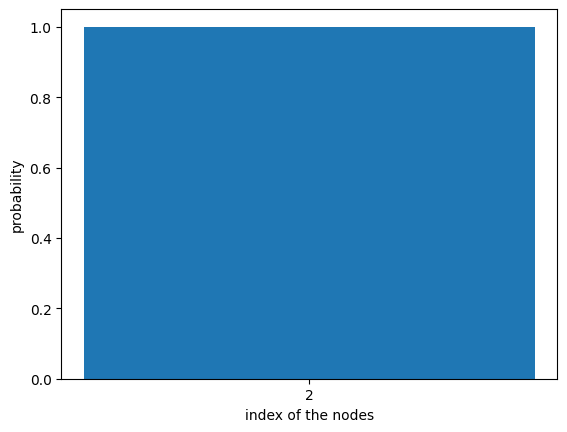

In [9]:
plot_bitstrings(counts_4_nodes_4_steps_sim["quantum_walk_measurement_counts"])

We see that the bar plots are consistent with our calculations for each step. One may be puzzled after comparing the bar plots for the third and the fourth steps, why the quantum walker can be shifted from the third node to its neighbor deterministically with a single step. 
This seems to be in contrast to the very first step where the amplitude is evenly distributed to the neighbors of the zeroth node. 
The reason is that after the third step, despite that the walker is deterministically found to be on the third node, the coin qubit is in a superposition state, in contrast to the very first step, where the coin is in the state of $|0\rangle$. 

# Run the quantum walk on a QPU

Let's now run the same quantum circuits on the Rigetti device, followed by inspecting the measurement results with bar plots.

Include estimated price for running in USD.


In [16]:
from braket.aws import AwsDevice

qpu = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")
counts_4_nodes_1_step_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_1_step, qpu)
counts_4_nodes_2_steps_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_2_steps, qpu)
counts_4_nodes_3_steps_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_3_steps, qpu)
counts_4_nodes_4_steps_qpu = run_quantum_walk(quantum_walk_circuit_4_nodes_4_steps, qpu)

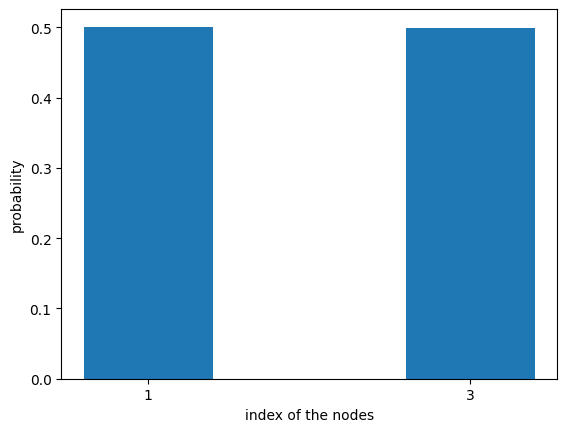

In [11]:
plot_bitstrings(counts_4_nodes_1_step_qpu["quantum_walk_measurement_counts"])

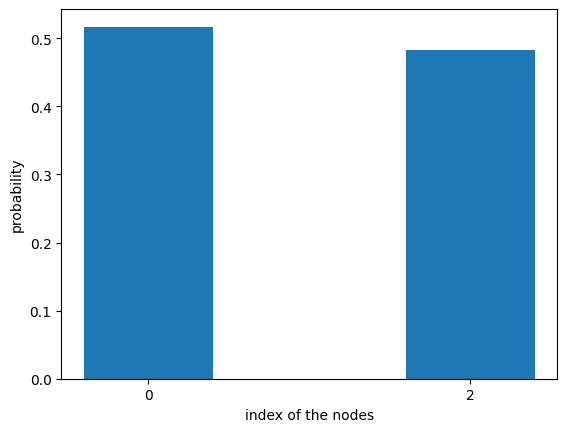

In [12]:
plot_bitstrings(counts_4_nodes_2_steps_qpu["quantum_walk_measurement_counts"])

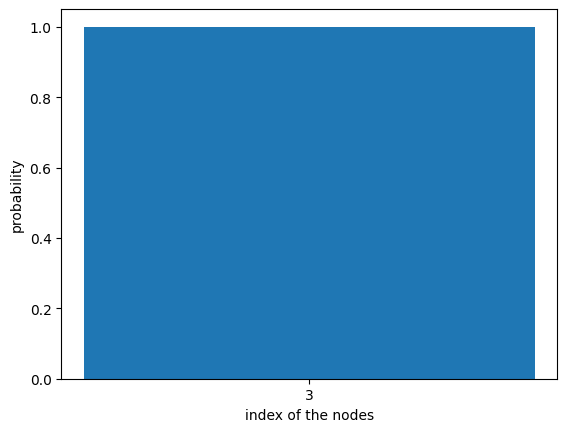

In [13]:
plot_bitstrings(counts_4_nodes_3_steps_qpu["quantum_walk_measurement_counts"])

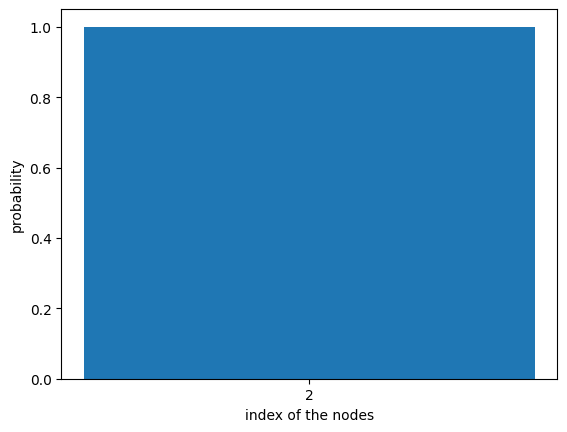

In [14]:
plot_bitstrings(counts_4_nodes_4_steps_qpu["quantum_walk_measurement_counts"])

Some comments of the noise

In [17]:
print("Task Summary")
print(f"{tracker.quantum_tasks_statistics()} \n")
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 4000, 'tasks': {'COMPLETED': 4}}} 

Estimated cost to run this example: 2.60 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).